In [1]:
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def load_masked_image(image_path, annotation_file_path):
    """
    Function for loading specific image with filled bounding boxes, which are presented in the format applicable
    for CrowdHuman model.
    param image_path: str (path to the image)
    param annotation_file_path: str(path to the annotation file, where corresponding annotation presents)
    return: np.array[np.int32](image)
    """
    image = np.array(Image.open(image_path))
    with open(annotation_file_path) as annotation_file:
        for line in annotation_file.readlines():
            current_json = json.loads(line)
            if current_json['ID'] != image_path.split('/')[-1][:-4]:
                continue
            for box in current_json['gtboxes']:
                if box['tag'] == 'person':
                    x, y, width, height = map(int, box['fbox'])
                    image[y:y+height, x:x+width] = 0
            return image
        
    raise ValueError('No annotation was found for specified image.')

In [3]:
def rename_extensions(folder_path, mapping_dict):
    """
    Function for changing files' extenstions in a directory.
    param folder_path: str(path to a directory, where extenstions need to be changed)
    param mapping_dict: dict(mapping dictionary)
    return: None
    """
    for file_name in os.listdir(folder_path):
        base = '.'.join(file_name.split('.')[:-1])
        extension = file_name.split('.')[-1].lower()
        if extension in mapping_dict:
            os.rename(os.path.join(folder_path, file_name), os.path.join(folder_path, base + '.' + mapping_dict[extension]))

In [4]:
extension_mapper = {
    'jpeg': 'jpg',
    'jpig': 'jpg'
}

**CrowdHuman** - dataset, which was used to fit the CrowdHuman model

In [5]:
dataset_path = 'datasets/CrowdHuman'

%cd $dataset_path

/tf/notebooks/tkachenko_detection/datasets/CrowdHuman


Since there are various extensions present in the Images folder, let's preserve only .jpg and .png

In [6]:
rename_extensions('Images', extension_mapper)

In [7]:
with open('annotation_train.odgt') as annotations_file:
    for line in annotations_file.readlines():
        image_json = json.loads(line)
        image_path = os.path.join('Images', image_json['ID'] + '.jpg')
        if os.path.exists(image_path):
            annotation = image_json['gtboxes']
            break

Let's look at annotations markup

In [8]:
annotation

[{'tag': 'person',
  'hbox': [285, 223, 25, 27],
  'head_attr': {'ignore': 0, 'occ': 0, 'unsure': 0},
  'fbox': [260, 221, 71, 232],
  'vbox': [260, 221, 71, 232],
  'extra': {'box_id': 0, 'occ': 0}},
 {'tag': 'person',
  'hbox': [217, 234, 18, 19],
  'head_attr': {'ignore': 0, 'occ': 0, 'unsure': 0},
  'fbox': [200, 233, 48, 161],
  'vbox': [200, 233, 48, 161],
  'extra': {'box_id': 1, 'occ': 0}},
 {'tag': 'person',
  'hbox': [170, 240, 16, 18],
  'head_attr': {'ignore': 0, 'occ': 1, 'unsure': 0},
  'fbox': [148, 238, 55, 156],
  'vbox': [148, 238, 55, 156],
  'extra': {'box_id': 2, 'occ': 0}},
 {'tag': 'person',
  'hbox': [144, 248, 6, 7],
  'head_attr': {'ignore': 0, 'occ': 1, 'unsure': 0},
  'fbox': [138, 247, 19, 43],
  'vbox': [138, 248, 18, 43],
  'extra': {'box_id': 3, 'occ': 1}},
 {'tag': 'person',
  'hbox': [126, 243, 7, 8],
  'head_attr': {'ignore': 0, 'occ': 1, 'unsure': 0},
  'fbox': [117, 242, 22, 52],
  'vbox': [122, 243, 16, 51],
  'extra': {'box_id': 4, 'occ': 1}},
 {'

In [9]:
original_image = np.array(Image.open(image_path))
masked_image = original_image.copy()

Annotations for each box are presented in the following format: (X, Y, WIDTH, HEIGHT)

In [10]:
for box in annotation:
    x, y, width, height = box['fbox']
    masked_image[y:y+height, x:x+width] = 0

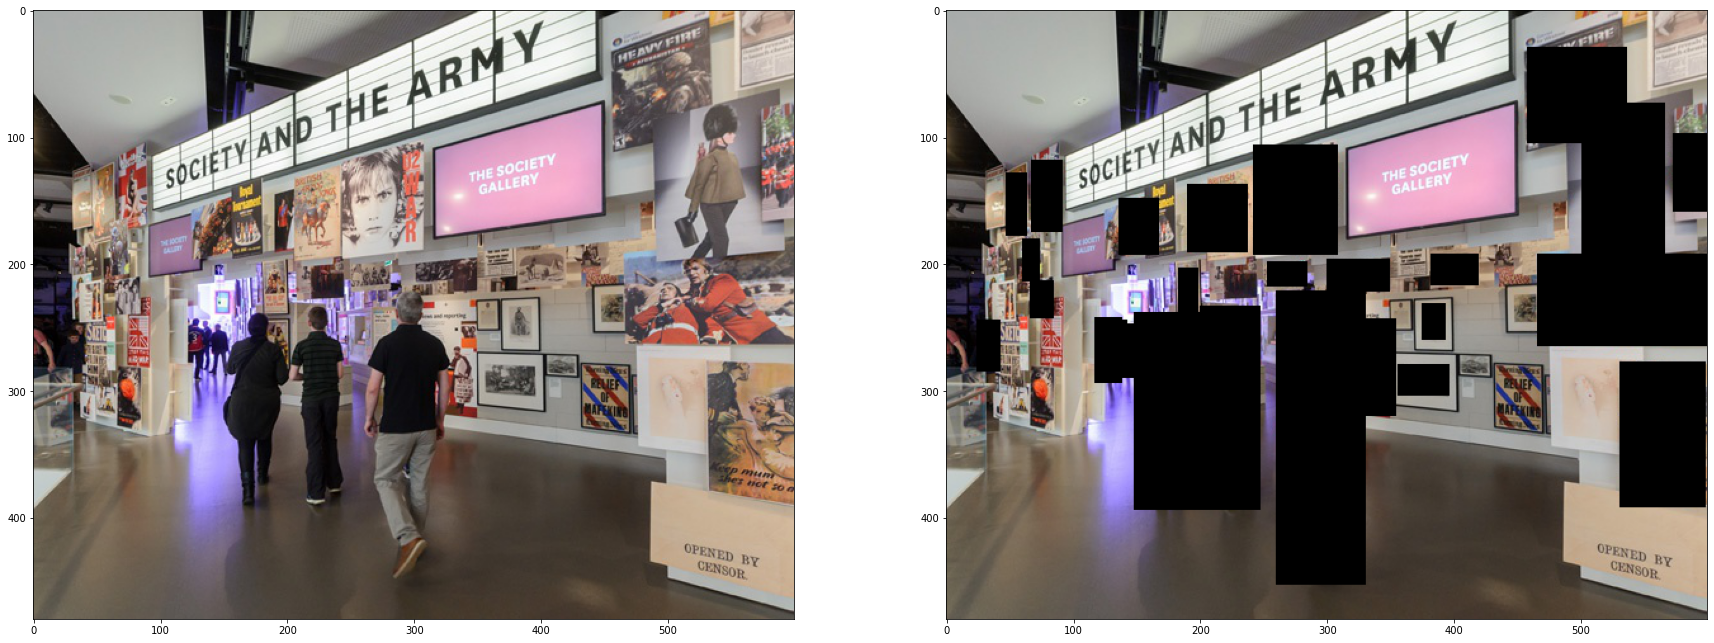

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))

axes[0].imshow(original_image)
axes[1].imshow(masked_image)

plt.show()

**Now let's explore datasets which will be used for finetuning the model**

**Night Dataset**

In [12]:
%cd ../..

/tf/notebooks/tkachenko_detection


In [13]:
dataset_path = 'datasets/night_dataset_labeled'
%cd $dataset_path

/tf/notebooks/tkachenko_detection/datasets/night_dataset_labeled


In [14]:
annotation_file_path = os.path.join('Annotations', os.listdir('Annotations')[0])
image_path = os.path.join('Images', annotation_file_path.split('/')[-1][:-4])

image_path

'Images/2015_06694.jpg'

Since there are various extensions present in the Images folder, let's preserve only .jpg and .png

In [15]:
rename_extensions('Images', extension_mapper)

Let's look at annotation markup. It is in format (X, Y, WIDTH, HEIGHT)

In [16]:
with open(annotation_file_path) as annotation_file:
    for line in annotation_file.readlines():
        print(line)

% bbGt version=3

People 873 267 454 907 0 0 0 0 0 0 0

People 453 292 406 878 0 0 0 0 0 0 0



Now let's mask bounding boxes on the image

In [17]:
original_image = np.array(Image.open(image_path))
masked_image = original_image.copy()

In [18]:
with open(annotation_file_path) as annotation_file:
    for line in annotation_file.readlines()[1:]:
        annotation = line.split(' ')[:5]
        if annotation[0] == 'People':
            x, y, width, height = map(int, annotation[1:])
            masked_image[y:y+height, x:x+width] = 0

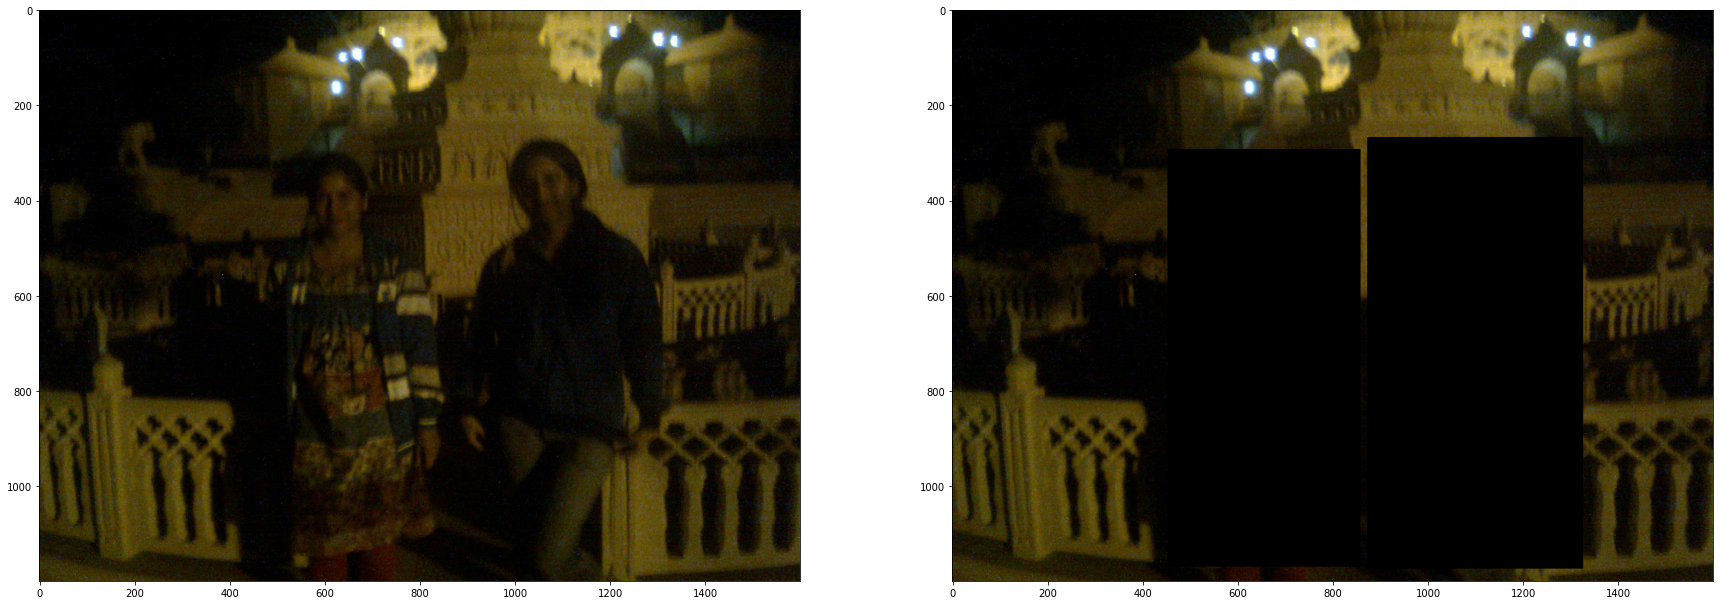

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))

axes[0].imshow(original_image)
axes[1].imshow(masked_image)

plt.show()

Now let's change annotation markup for this dataset, so it can be used with CrowdHuman model

In [20]:
annotations = []

for annotation_file_path in os.listdir('Annotations'):
    annotation_dict = {'ID': annotation_file_path.split('.')[0], 'gtboxes': []}
    
    with open(os.path.join('Annotations', annotation_file_path)) as current_annotation_file:
        for line in current_annotation_file.readlines()[1:]:
            current_annotation = line.split(' ')[:5]
            
            if current_annotation[0] != 'People':
                continue
            
            annotation_dict['gtboxes'].append({
                'tag': 'person',
                'fbox': list(map(int, current_annotation[1:]))
            })
    
    if annotation_dict['gtboxes']:
        annotations.append(annotation_dict)

In [21]:
with open('annotations.odgt', 'w') as outfile:
    for annotation in annotations:
        json.dump(annotation, outfile)
        outfile.write('\n')

For some reason model can't be trained with images, which have only one bounding box on them. So here I will split all images into train/val sets. Train set will consist of images, which have >1 bounding boxes, validation set - with others.

In [22]:
# %cd ~/../tf/notebooks/tkachenko_detection/datasets/night_dataset_labeled

# with open('annotations.odgt') as annotations_file:
#     annotations_lines = annotations_file.readlines()
    
# train_lines = []
# val_lines = []
    
# for line in annotations_lines:
#     train_lines.append(line) if len(json.loads(line)['gtboxes']) > 1 else val_lines.append(line)
    
# with open('train_annotations.odgt', 'w') as outfile:
#     outfile.writelines(train_lines)

# with open('val_annotations.odgt', 'w') as outfile:
#     outfile.writelines(val_lines)

Let's check if obtained annotations are valid

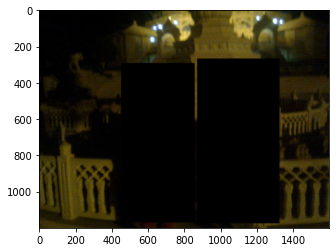

In [23]:
image = load_masked_image('Images/2015_06694.jpg', 'annotations.odgt')
plt.imshow(image)

**WiderPerson dataset**

In [24]:
%cd ../..

/tf/notebooks/tkachenko_detection


In [25]:
dataset_path = 'datasets/WiderPerson'

%cd $dataset_path

/tf/notebooks/tkachenko_detection/datasets/WiderPerson


Since there are various extensions present in the Images folder, let's preserve only .jpg and .png

In [26]:
rename_extensions('Images', extension_mapper)

In [27]:
annotation_file_path = os.path.join('Annotations', os.listdir('Annotations')[0])
image_path = os.path.join('Images', annotation_file_path.split('/')[-1][:-4])

image_path

'Images/013388.jpg'

Let's look at annotation markup. It is presented in format: (X1, Y1, X2, Y2)

In [28]:
with open(annotation_file_path) as annotation_file:
    for line in annotation_file.readlines():
        print(line)

45

1 0 1059 246 1832

1 294 1070 441 1430

1 335 998 517 1445

1 473 1025 625 1397

1 857 1033 999 1380

1 1197 1127 1416 1664

1 1304 1054 1420 1340

1 1358 1045 1478 1337

1 1494 1091 1596 1339

1 1571 1074 1664 1303

1 1627 1065 1726 1310

1 1657 1075 1754 1312

1 1672 1059 1759 1274

1 1728 1043 1832 1298

1 1754 1080 1858 1333

1 1780 1085 2009 1643

1 2161 1111 2242 1310

1 2109 1116 2183 1300

1 2021 1090 2098 1277

1 1959 1087 2057 1326

1 2346 1127 2424 1320

1 2372 1115 2451 1311

1 2405 1092 2493 1308

1 2450 1104 2535 1314

1 2528 1131 2603 1316

1 2542 1085 2744 1577

1 2540 1098 2629 1316

1 2669 1096 2757 1314

1 2694 1104 2779 1315

1 2759 1094 2849 1314

1 2809 1118 2892 1323

1 2861 1125 2938 1313

1 2910 1129 2986 1314

1 2929 1116 3011 1316

1 2969 1107 3051 1310

1 2984 1107 3072 1325

1 3024 1105 3111 1319

1 3070 1066 3186 1349

1 3189 1119 3264 1303

3 1079 1151 1128 1255

3 1129 1162 1198 1240

3 1862 1051 1900 1098

3 1837 1070 1873 1108

3 1893 1080 1947 116

In [29]:
original_image = np.array(Image.open(image_path))
masked_image = original_image.copy()

In [30]:
with open(annotation_file_path) as annotation_file:
    for line in annotation_file.readlines()[1:]:
        annotation = line.split(' ')[:5]
        if annotation[0] in '135':
            x1, y1, x2, y2 = map(int, annotation[1:])
            masked_image[y1:y2, x1:x2] = 0

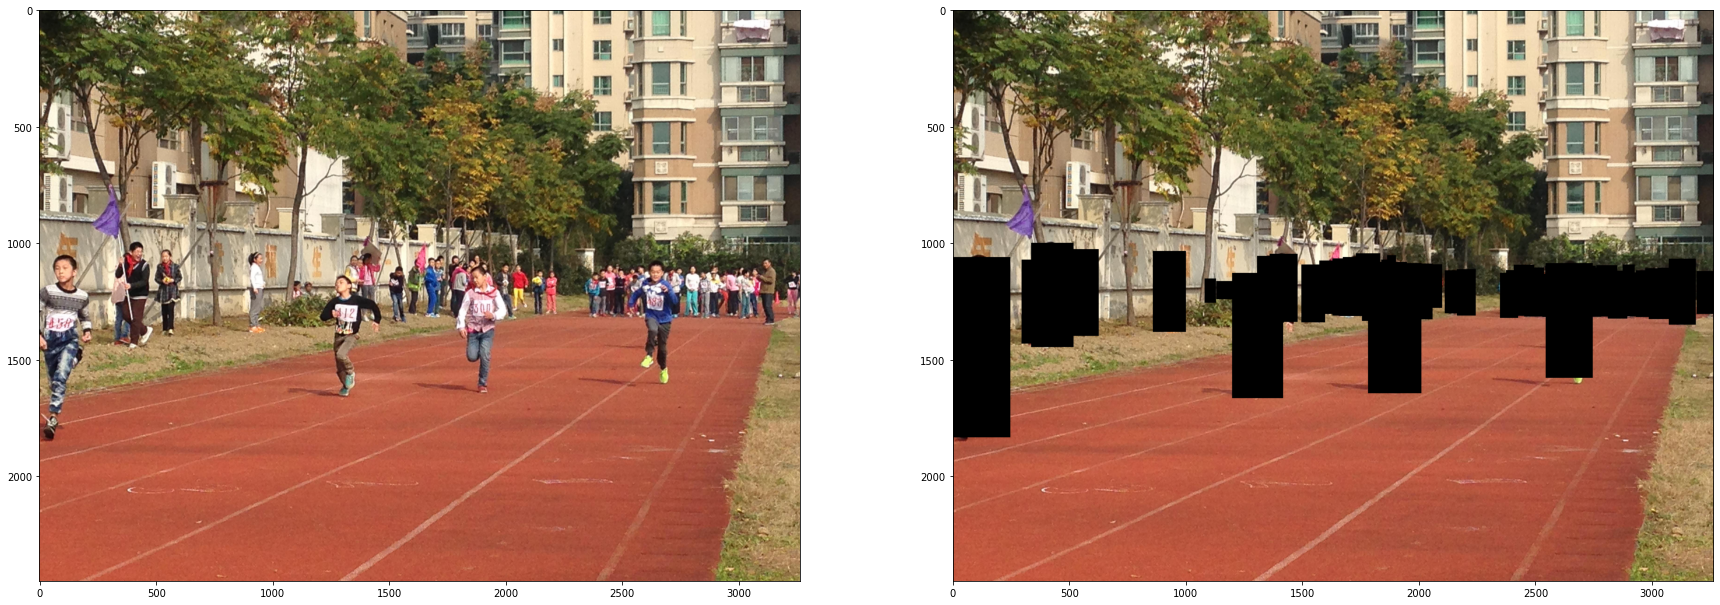

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))

axes[0].imshow(original_image)
axes[1].imshow(masked_image)

plt.show()

Now let's change annotation markup for this dataset, so it can be used with CrowdHuman model

In [32]:
annotations = []

for annotation_file_path in os.listdir('Annotations'):
    annotation_dict = {'ID': annotation_file_path.split('.')[0], 'gtboxes': []}
    
    with open(os.path.join('Annotations', annotation_file_path)) as current_annotation_file:
        for line in current_annotation_file.readlines()[1:]:
            current_annotation = line.split(' ')[:5]
            
            if current_annotation[0] not in '135':
                continue
            
            x1, y1, x2, y2 = list(map(int, current_annotation[1:]))
            
            annotation_dict['gtboxes'].append({
                'tag': 'person',
                'fbox': [x1, y1, x2-x1, y2-y1]
            })
    
    if annotation_dict['gtboxes']:
        annotations.append(annotation_dict)

In [33]:
with open('annotations.odgt', 'w') as outfile:
    for annotation in annotations:
        json.dump(annotation, outfile)
        outfile.write('\n')

Let's check if obtained annotations are valid

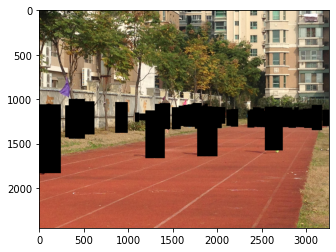

In [34]:
image = load_masked_image('Images/013388.jpg', 'annotations.odgt')
plt.imshow(image)